## Description 
This notebook contains a basic implementation of a Keras image segmentation model for the [Sartorius - Cell Instance Segmentation competition](https://www.kaggle.com/c/sartorius-cell-instance-segmentation/data) using 
[Segmentation Models: "Python library with Neural Networks for Image Segmentation based on Keras and TensorFlow. "](https://github.com/qubvel/segmentation_models). This library contains four models architectures for image segmentation: UNet, LinkNet, PSPNet, and FPN.

Here a UNet with a DenseNet121 backbone is implemented, but you could try the other models (LinkNet, PSPNet, or FPN) using the 25 available backbones (such as ResNet, MobileNet, DenseNet, etc.). By now, this implementation is unable to achieve a good score (> 0.0), it only provides a way for test different segmentation models with the competition's dataset. It also uses Jaccard loss and IOU score for training. 

## Problem definition
Data: 

[Phase-contrast microscopy](https://en.wikipedia.org/wiki/Phase-contrast_microscopy) images of human neuronal cell  types along with annotations (labels) representing cell segmentations. 

Aim: 

The trained model should be able to predict the annotations for cell segmentation, including rare cell types (such as neuroblastoma cell line SH-SY5Y as discussed in the [competition description](https://www.kaggle.com/c/sartorius-cell-instance-segmentation/overview)). Annotations should be provided in run-length format (see functions rle_decode() and rle_encode below).

## Approach 
[Segmentation models library](https://github.com/qubvel/segmentation_models): 

"The main features of this library are:

*     High level API (just two lines of code to create model for segmentation)
*     4 models architectures for binary and multi-class image segmentation (including legendary Unet)
*     25 available backbones for each architecture
*     All backbones have pre-trained weights for faster and better convergence
*     Helpful segmentation losses (Jaccard, Dice, Focal) and metrics (IoU, F-score)"


Reference notebooks:
1. [Cell Segmentation - Run Length Decoding](https://www.kaggle.com/ihelon/cell-segmentation-run-length-decoding).
2. [Sartors TF starter](https://www.kaggle.com/barteksadlej123/sartors-tf-starter).
3. [Positive score with Detectron 3/3 - Inference](https://www.kaggle.com/dragonzhang/positive-score-with-detectron-3-3-inference).

Other references: 
1. [Tensorflow Tutorials: Image segmentation ](https://www.tensorflow.org/tutorials/images/segmentation).
2. [Segmentation models documentation](https://segmentation-models.readthedocs.io/en/latest/).


## Workflow

[1. Imports](#section-1)

[2. Functions](#section-2)

[3. Constants](#section-3)

[4. Generate train and validation data sets](#section-4)

[5. Define the model](#section-5)

[6. Training](#section-6)

[7. Test set predictions](#section-7)



<a id="section-1"></a>
### 1. Libraries and paths

In [1]:
# install Segmentation Models 
!pip install -U segmentation-models

     |████████████████████████████████| 50 kB 3.5 MB/s eta 0:00:01


In [2]:
# required libraries 
import numpy as np 
import pandas as pd
import os
from pathlib import Path
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing

import segmentation_models
segmentation_models.set_framework('tf.keras')
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from IPython.display import clear_output
import matplotlib.pyplot as plt

Segmentation Models: using `keras` framework.


<a id="section-2"></a>
### 2. Functions

In [3]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background.
    ref: https://www.kaggle.com/inversion/run-length-decoding-quick-start
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    ref: https://www.kaggle.com/dragonzhang/positive-score-with-detectron-3-3-inference
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def get_mask(image_id, df):
    '''
    Uses rle_decode() to get ndarray from mask using image_id in dataframe (df).
    ref: https://www.kaggle.com/barteksadlej123/sartors-tf-starter
    '''
    current = df[df["id"] == image_id]
    labels = current["annotation"].tolist()
    
    mask = np.zeros((HEIGHT, WIDTH))
    for label in labels:
        mask += rle_decode(label, (HEIGHT, WIDTH))
    mask = mask.clip(0, 1)
    
    return mask


#  fix overlaps: 

def check_overlap(msk):
    '''
    Checks if there are overlap in a mask (msk).
    ref: https://www.kaggle.com/awsaf49/sartorius-fix-overlap
    '''
    msk = msk.astype(np.bool).astype(np.uint8)
    return np.any(np.sum(msk, axis=-1)>1)


def fix_overlap(msk):
    '''
    Args:
        mask: multi-channel mask, each channel is an instance of cell, shape:(520,704,None)
    Returns:
        multi-channel mask with non-overlapping values, shape:(520,704,None) 
    ref: https://www.kaggle.com/awsaf49/sartorius-fix-overlap
    '''
    msk = np.array(msk)
    msk = np.pad(msk, [[0,0],[0,0],[1,0]])
    ins_len = msk.shape[-1]
    msk = np.argmax(msk,axis=-1)
    msk = tf.keras.utils.to_categorical(msk, num_classes=ins_len)
    msk = msk[...,1:]
    msk = msk[...,np.any(msk, axis=(0,1))]
    return msk


# make predictions for test set: 

def make_predictions(dataset, num, keras_model, check_overlaps=False):
    '''
    For a tf.Dataset, makes predictions for n=num (num =-1 or all_images takes all images in the dataset), 
    images using a keras_model. Returns a list of predicted masks, each as ndarray. 
    '''
    predictions = []
    if dataset:
        for image in dataset.take(num):
            image = image[None]
            pred_mask = keras_model.predict(image)
            # changes shape from (1,512,512,1) to (512,512)
            pred_mask = pred_mask[0, :, :, 0]
            # fix overlaps
            if check_overlaps:
                if check_overlap(msk=pred_mask):
                    pred_mask = pred_mask[None]
                    pred_mask = fix_overlap(msk=pred_mask)
            # transforms ndarray values to 0s and 1s
            pred_mask =  np.where( pred_mask > 0.5, 1, 0)
            predictions.append(pred_mask)
    return predictions


def display(display_list):
    '''
    Displays an example image and mask 
    '''
    plt.figure(figsize=(20, 20))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

    
# functions to visualize predictions:

def create_mask(pred_mask):
    '''Converts predicted mask values to 0s and 1s'''
    pred_mask = tf.where(pred_mask > 0.5,1,0)
    return pred_mask

def show_predictions(keras_model, dataset=None, num=1):
    '''
    Shows N=num predictions examples from dataset and a keras_model 
    '''
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = keras_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask[0])])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...])[0])])


<a id="section-3"></a>
### 3. Constants 

In [4]:
# constants

DEBUG = False

SEED = 123
WIDTH, HEIGHT = 704, 520
RESIZE_WIDTH, RESIZE_HEIGHT = 512, 512
BATCH_SIZE = 4
BUFFER_SIZE = 32

## in a segmentation task each pixel is given a class 
## OUTPUT_CLASSES: number of classes that can be assigned to each pixel 
OUTPUT_CLASSES = 1

# architecture backbone for segmentation model
BACKBONE = 'densenet121'

VAL_SPLIT = 0.2

AUTO = tf.data.AUTOTUNE

EPOCHS = 100

In [5]:
# paths

# input
DIR = '../input/sartorius-cell-instance-segmentation'
train_csv = os.path.join(DIR,'train.csv') 
train_path =  os.path.join(DIR, 'train/')
test_path = os.path.join(DIR, 'test/')

# output 
csv_output = os.path.join('./', 'submission.csv') 
model_output = os.path.join('./', 'unet_keras_' + BACKBONE + '_backbone.h5')

<a id="section-4"></a>
### 4. Generate train and validation data sets

In [6]:
# train and validation split
train = pd.read_csv(train_csv)
train.head()

n_ids = train.id.nunique()

if DEBUG:
    unique_ids_train = list(set(train['id'].tolist()))[:BATCH_SIZE]
    unique_ids_valid = list(set(train['id'].tolist()))[BATCH_SIZE:2*BATCH_SIZE]
else:
    unique_ids_train = list(set(train['id'].tolist()))[:int(n_ids * (1 - VAL_SPLIT))]
    unique_ids_valid = list(set(train['id'].tolist()))[int(n_ids * (1 - VAL_SPLIT)):]


temp = pd.DataFrame()
for sample_id in unique_ids_train:
    query = train[train.id == sample_id]
    temp = pd.concat([temp, query])
train = temp
train = train.reset_index(drop=True)

temp = pd.DataFrame()
for sample_id in unique_ids_valid:
    query = train[train.id == sample_id]
    temp = pd.concat([temp, query])
valid = temp
valid = train.reset_index(drop=True)
    
TRAIN_LENGTH = train['id'].nunique()
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VALID_LENGTH = valid['id'].nunique()
VALIDATION_STEPS = VALID_LENGTH // BATCH_SIZE

In [7]:
# training/validation data generator 

preprocess_input = get_preprocessing(BACKBONE)

def train_generator(df):
    image_ids = set(df['id'].tolist())
    
    for image_id in image_ids:
        
        image = cv2.imread(os.path.join(train_path, image_id) + '.png')
        image = preprocess_input(image)
        image = cv2.resize(image, (RESIZE_HEIGHT, RESIZE_WIDTH))

        mask = get_mask(image_id, df)        
        mask = cv2.resize(mask, (RESIZE_HEIGHT, RESIZE_WIDTH))
        
        mask = mask.reshape((*mask.shape, 1))
        
        image = image.astype(np.float32)
        mask = mask.astype(np.float32)
        
        yield image, mask

In [8]:
# use the generator to get training and validation sets
train_ds = tf.data.Dataset.from_generator(
    lambda : train_generator(train), 
    output_types=(tf.float32, tf.float32),
    output_shapes=((RESIZE_HEIGHT, RESIZE_WIDTH, 3), (RESIZE_HEIGHT, RESIZE_WIDTH, 1)))

valid_ds = tf.data.Dataset.from_generator(
    lambda : train_generator(valid), 
    output_types=(tf.float32, tf.float32),
    output_shapes=((RESIZE_HEIGHT, RESIZE_WIDTH, 3), (RESIZE_HEIGHT, RESIZE_WIDTH, 1)))


2021-11-08 18:45:30.022949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 18:45:30.107881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 18:45:30.108564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-08 18:45:30.111406: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
# "the following class performs a simple augmentation by randomly-flipping an image"
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=SEED):
        super().__init__()
        
        self.augment_inputs = preprocessing.RandomFlip('horizontal', seed=seed)
        self.augment_labels = preprocessing.RandomFlip('horizontal', seed=seed)
        
    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [10]:
# "build the input pipeline, applying the augmentation after batching the inputs"
# for augmentation only add .map(Augment()) after .repeat() 

train_ds = (
    train_ds
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(AUTO))

valid_ds = (
    valid_ds
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTO))

2021-11-08 18:45:32.661018: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


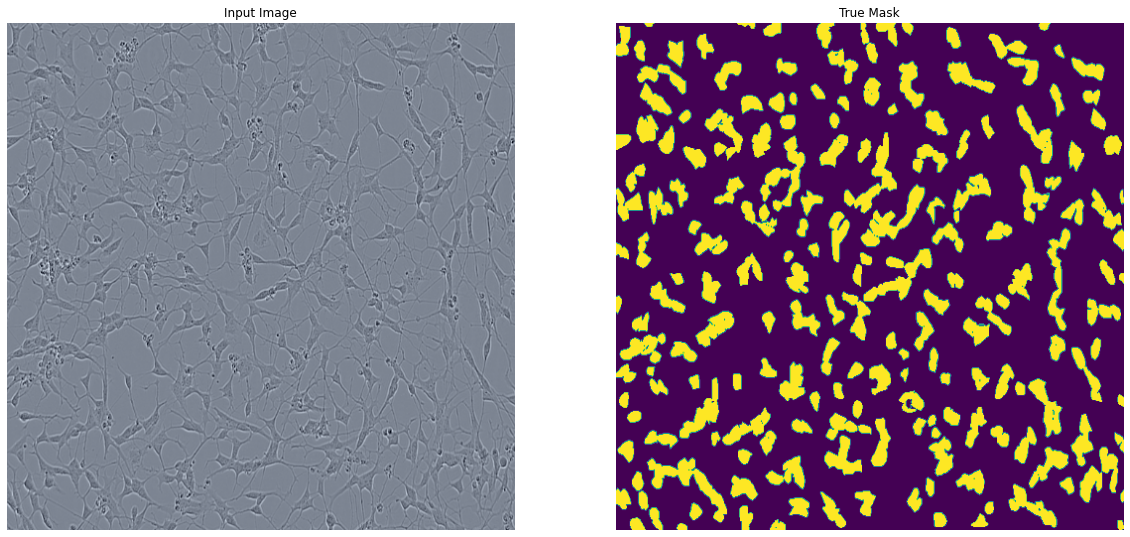

In [11]:
# "visualize an image example and its corresponding mask from the dataset"    
for images, masks in train_ds.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

<a id="section-5"></a>
### 5. Define the model 

In [12]:
# model defininition

# "encoder_freeze: if True set all layers of encoder (backbone model) as non-trainable"  
model = Unet(backbone_name=BACKBONE, 
                encoder_weights='imagenet', 
                activation='sigmoid',
                classes=OUTPUT_CLASSES,
                encoder_freeze=True)

29097984/29084464 [==============================] - 0s 0us/step


In [13]:
# compile model 

# optimizer 
opt = keras.optimizers.Adam(learning_rate=1e-3)

# loss from Segmentation Models
# can be customized using sm.segmentation_models.losses.JaccardLoss()
# metrics from Segmentation Models, 
# can be customized using sm.segmentation_models.metrics.IOUScore() function
model.compile(optimizer=opt,
              loss=bce_jaccard_loss,
              metrics=[iou_score])

<a id="section-6"></a>
### 6. Training

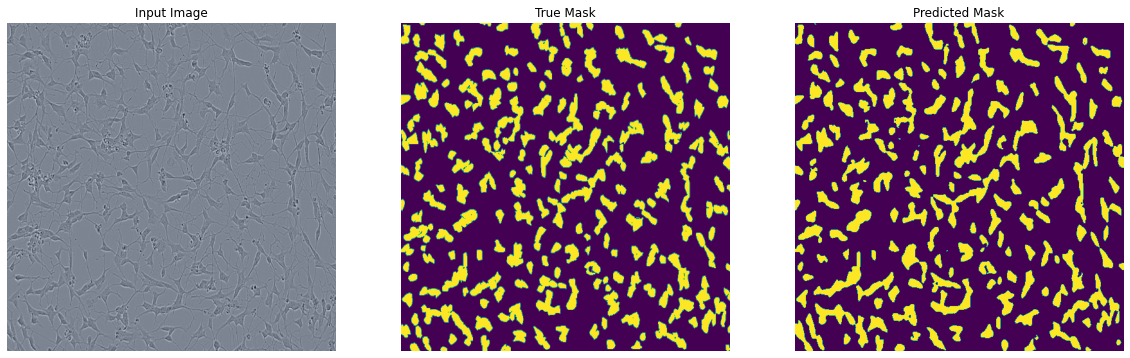


Sample Prediction after epoch 100



In [14]:
# training

# "observe how the model improves while it is training"
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=False)
        show_predictions(keras_model=model)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
# display callback defined above
display_cb = DisplayCallback()


# "save the Keras model or model weights at some frequency"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_output,
    save_best_only=True,
    save_weights_only=False,
)

# "reduce learning rate when a metric has stopped improving"
# documentation: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=10, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

model_history = model.fit(train_ds, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=valid_ds,
                          callbacks=[display_cb, model_checkpoint, lr_reduce])

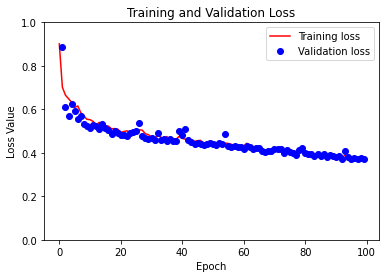

In [15]:
# plot training curve
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

<a id="section-7"></a>
### 7. Test set predictions

In [16]:
# test data generator 
test_ids = [  os.path.join(test_path, each)  for each in os.listdir(test_path) if each.endswith('.png')]
def test_generator(image_ids):
    for image_id in image_ids:
        image = cv2.imread(image_id) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)        
        image = cv2.resize(image, (RESIZE_HEIGHT, RESIZE_WIDTH))
        image = image.astype(np.float32)
        yield image

In [17]:
# test dataset from test data generator 
test_ds = tf.data.Dataset.from_generator(
    lambda : test_generator(test_ids), 
    output_types=(tf.float32),
    output_shapes=((RESIZE_HEIGHT, RESIZE_WIDTH, 3)) )

In [18]:
# test image ids and predictions
test_predictions = make_predictions(dataset=test_ds, 
                                    num=len(test_ids), 
                                    keras_model=model,
                                    check_overlaps=True)

In [19]:
# encode predections in the RL format
test_predictions = [rle_encode(mask) for mask in test_predictions] 

In [20]:
# transform full image paths to ids 
test_ids = [Path(ID).stem for ID in test_ids]

In [21]:
# generate submission data frame 
submisssion = pd.DataFrame.from_dict({'id': test_ids, 'predicted': test_predictions} )
submisssion = submisssion.sort_values( ['id'], ascending=True )
print(submisssion.head(), 'n')
submisssion.to_csv(csv_output, index=False)

             id                                          predicted
0  7ae19de7bc2a  75 1 90 1 105 1 120 1 135 1 150 1 165 1 180 1 ...
2  d48ec7815252  16 1 20 1 24 1 28 1 32 1 36 1 40 1 44 1 48 1 5...
1  d8bfd1dafdc4  14 1 16 1 18 1 20 1 22 1 24 1 26 1 28 1 30 1 3... n
